In [199]:
import numpy as np
from scipy import constants
import scipy.interpolate
import time
import math
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
#import scipy
#from astropy.constants import h, c
%matplotlib inline


In [200]:
def mag2flux(mag, zero_pt=21.1, ABwave=None):
    if ABwave != None:
        return 10.**(-0.4*(mag+2.406+5*np.log10(ABwave)))
    return 10.**(-0.4*(mag+zero_pt))

In [201]:
def planck(wave, temp):
    w=wave/1e8
    c1 =  3.7417749e-5  #=2*!DPI*h*c*c   
    c2 = 1.4387687    # =h*c/k
    val=c2/w/temp
    bbflux=c1/(w**5 * (math.e**val-1))*1e-8
    return bbflux


In [202]:
def gen_cal(wave, cdir, calname):
    calfile=cdir+calname
    lwave=calfile['col1']
    lflux=calfile['col2']
    caldata=scipy.interpolate.spline(lwave, lflux, wave)
    nline=len(lwave)
    nwave=len(wave)
    flux_out=wave*0.
    for i in range(nline):
        if (lwave[i] < wave[0]) or (lwave[i] > wave[-1]):
            continue
        diff=np.absolute(wave-lwave[i])
        sort_idx=np.argsort(diff)
        nrst_idx=sort_idx[0]
        binsize=wave[nrst_idx+1]-wave[nrst_idx]
        nflux=lflux[i]/binsize
        flux_out[nrst_idx]=nflux*1e-8
    return flux_out
        

In [203]:
def flux2bpmag(flam, wave, filtertrans_input, filterwave=None,
               errflag=None, flam_err=None, bpmag_err=None):

    mintrans=0.0001
    filtertrans=filtertrans_input
    if filterwave != None:
        #filtertrans=interpol(filtertrans, filterwave, wave)
        filtertrans=scipy.interpolate.spline(filterwave, filtertrans, wave)
    filtertrans=(filtertrans >= mintrans)*filtertrans
    
    nwave=len(wave)

    if len(filtertrans) != nwave:
        errflag=1
        return
    
    constc=constants.c

    filtertrans=filtertrans.astype('d')

    flux=np.sum(flam*filtertrans)
#       refflam=replicate(3631.d-23, nwave)/wave^2.*!const.c*1.d10
    #refflam=replicate(3631.d-23, nwave)/wave^2.*constc*1.d10
    
    refflam=np.ones(nwave)*3631e-23/wave**2.*constc*1e10
    
    refflux=np.sum(refflam*filtertrans)
    if flam_err != None:
        err=(np.sum((flam_err*filtertrans)**2))**0.5
        bpmag_err=-2.5/np.log(10)/flux*err

    bpmag=-2.5*np.log10(flux/refflux)
    return bpmag
 

In [204]:
def return_littrow_ghost(wave, signal, ccdreflect, cam, g1stR, g1st, g0th):
#       lghost=return_littrow_ghost(wave,signal+skysignal, ccdreflect, camtrans, g1stR, g1st, g0th)
    rsub=0.01 #;reflectivity of the grating substrate
    lghost1=np.sum(signal*ccdreflect*cam*cam*g1stR)
    lghost2=np.sum(signal*ccdreflect*cam*cam*g1st*rsub*g0th)
    print('Littrow ghost 1 and 2 ', lghost1, lghost2)
    lgwave=4800.
    lghost=signal*0

    diff=np.absolue(wave-lgwave)
    sort_idx=np.argsort(diff)
    nrst_idx=sort_idx[0]
    binsize=wave[nrst_idx+1]-wave[nrst_idx]
    

    tghost=(lghost1+lghost2)
    
    lghost[nrst_idx]=tghost
    return lghost

In [218]:
def return_flux(source, wave, magnitude, band, z, exptime, wstep, cdir, 
                bbtemp, stype):
 #Identify source type
    consth=constants.h
    constc=constants.c
    src_check=source.split('_')
    src_type=src_check[0]
    skyflag=0
    if len(src_check) == 2:
        src_value=src_check[1]

    
    nwave=len(wave)

    if src_type =='const':
        magarr=np.ones(nwave)*magnitude
        photone=consth*1e7*constc/(wave*1e-10)
        sourceflux=mag2flux(magnitude, ABwave=wave)
        temptitle='Constant Magnitude of'
        #constflux=replicate(sourceflux[n_elements(sourceflux)/2], nwave)
        #sourceflux=constflux
    
    if src_type =='gal':
        galtempname=cdir+'kc96/'+src_value+'_template.ascii'
        galfile=ascii.read(galtempname, data_start=0)
        galwave=galfile['col1']*(1.+z)
        galflam=galfile['col2']/(1.+z)
        galflux=scipy.interpolate.spline(galwave, galflam, wave) 

        bpmag=flux2bpmag(galflux, wave, band)

        ratio=10.**(-0.4*(magnitude-bpmag))
        sourceflux=ratio*galflux
        cc=(((wave >= min(galwave)) & (wave <= max(galwave))))

        
        sourceflux=sourceflux*((wave >= min(galwave)) & (wave <= max(galwave)))
        temptitle='Type Galaxy'
        skyflag=1
    
#    if src_type =='skyflat':

    if src_type =='arcflat':
        arcname=cdir+'Xenon_lamp.txt'
        arcfile=ascii.read(arcname, data_start=0)
        xwave=arcfile['col1']
        xflam=arcfile['col2']
        sourceflux=scipy.interpolate.spline(xwave, xflam, wave)*10.**(-12.)
        sourceflux=sourceflux*((wave >= min(xwave)) & (wave <= max(xwave)))
        temptitle='Xenon Arc Lamp'

    if src_type =='blackbody':
        sourceflux=planck(wave, bbtemp)*0.015**2.*np.pi/(1e5)**2
        temptitle='Black Body (T='

    if src_type =='wavecal':
        sourceflux=gen_cal(wave, cdir, src_value)
        temptitle='Wavelength Calibration Source - '
    
    if src_type =='sky':
        skyfilearr=['sky150701_newmoon_alt90.dat',
                    'sky160311_newmoon_alt45.dat',
                    'sky160311_halfmoon.dat',
                    'sky160311_fullmoon.dat']
        skyname=cdir+skyfilearr[stype]
        #skyfile=ascii.read(skyname, data_start=37)
        #skywave=skyfile['col1']*10
        #skyflam=skyfile['col2']
        skyfile=ascii.read(skyname, data_start=24)
        skywave=skyfile['Input']*10
        skyflam=skyfile['Configuration']
        skyflux=scipy.interpolate.spline(skywave, skyflam, wave)
        bpmag=flux2bpmag(skyflux, wave, band)
        ratio=10.**(-0.4*(magnitude-bpmag))
        sourceflux=ratio*skyflux
        sourceflux=sourceflux*((wave >= min(skywave)) & (wave <= max(skywave)))
        temptitle='Sky'

    
    return sourceflux, temptitle, skyflag

In [220]:
#class dotifs_etc(object):
#    def __init__(self, exptime=900, band='r', magnitude=17., 
 #                oname='snr.ps', galtemp=False, z=0., inputflux=None, inputwave=None, 
#                 #bbtemp=False, wavecal=False, skyflat=False, arcflat=False,
#                 source='gal_sc', bbtemp=5000, scflag=False, 
#                 stype=0, skymagnitude=22., nofilter=False,
#                 noplot=False, plotrange=[3700, 7400], wstep=(3700./3000), pixel=None, 
#                 cspline=False, wavearr=None,
#                 waveout=None, snrout=None, signalarr=None, skysignalarr=None, noisearr=None, noiseskyarr=None, 
#                 dtypes=None, ofile='outdata.txt', 
#                 pri=3.6, sec=0.915, skysamplingsize=0.4**2*math.pi, dispersion=3700/(3000*15), pixelsize=15,
#                 npix_spa=5, rn=2, dark=0,
#                 cdir='/home/hchung/dotifs/py_etc/',
#                ):
        
exptime=900
band='r'
magnitude=20.
oname='snr.ps'
galtemp=False
z=0.
inputflux=None
inputwave=None
#bbtemp=False, wavecal=False, skyflat=False, arcflat=False,
source='gal_sc'
bbtemp=5000
scflag=False, 
stype=0
skymagnitude=22.
nofilter=False
noplot=False
plotrange=[3700, 7400]
wstep=(3700./3000)
pixel=None
cspline=False
wavearr=None
waveout=None
snrout=None
signalarr=None
skysignalarr=None
noisearr=None
noiseskyarr=None
dtypes=None
ofile='outdata.txt'
pri=3.6
sec=0.915
skysamplingsize=0.4**2*math.pi
dispersion=3700/(3000*15)
pixelsize=15
npix_spa=5
rn=2
dark=0
cdir='/home/hchung/dotifs/py_etc/'


use_asahi=1
ltrghost=False
consth=constants.h
constc=constants.c
temptitle='None'

ifutrans=0.85*0.9
telaream2=(pri**2-sec**2)/4*math.pi         #in m^2
telarea=telaream2*1e4                           #in cm^2
pixelscale=dispersion*pixelsize
if pixel != None:
    wstep=pixel*pixelscale
if pixel == None:
    pixel=wstep/pixelscale

stwave=plotrange[0]
edwave=plotrange[1]


transfname=cdir+'trans150626.dat'
#data=ascii.read(transfile, format='no_header')
transfile=ascii.read(transfname, data_start=1)
wavemicron=np.array(transfile['micron'])
waveang=wavemicron*1e4
skytrans=np.array(transfile['SkyTrans'])
telmag=np.array(transfile['telandmag'])
col=np.array(transfile['col'])
cam=np.array(transfile['cam'])
#        ccd=np.array(transfile['ccd'])
g0th_o=np.array(transfile['0th'])
g1st_o=np.array(transfile['1st'])
g2nd_o=np.array(transfile['2nd'])

vphfname=cdir+'vph_160307_new.dat'
vphfile=ascii.read(vphfname, data_start=1)

coatfname=cdir+'altcoating.dat'
coatfile=ascii.read(coatfname, data_start=1)     

ccdfname=cdir+'ccd_multi2.txt'
ccdfile=ascii.read(ccdfname, data_start=1)

bandname=cdir+band+'filter.dat'
bandfile=ascii.read(bandname, data_start=2)

afiltername=cdir+'asahi_filter_01.dat'
afilterfile=ascii.read(afiltername, data_start=0)
awave=afilterfile['col1']
atrans=afilterfile['col2']
awave=np.flip(awave,0)*10
atrans=np.flip(atrans,0)/100


if wavearr == None:
    nwave=int((waveang[-1]-waveang[0])/wstep)+1
    wave=np.linspace(0, nwave-1, num=nwave)*wstep+waveang[0]
else:
    wave=np.array(wavearr)
    nwave=len(wavearr)
    



idx=np.nonzero((wave > 3700) & (wave < 7400))
#idx2=np.nonzero((awave > 3700) & (awave < 7400))
#print(awave[idx2])
#print(atrans[idx2])


if cspline:
    eff_vph_new=scipy.interpolate.spline(vphfile['wave_new'],
                                         vphfile['vph_trans'],
                                         waveang/10)
    eff_coat=scipy.interpolate.spline(coatfile['wavenm'],
                                      coatfile['t0'],
                                      waveang/10)/100
    ccd=scipy.interpolate.spline(ccdfile['Wave'],
                                 ccdfile['QE'],
                                 waveang/10)
    band=scipy.interpolate.spline(bandfile['col1'],
                                  bandfile['col2'],
                                  wave)
    afilter=scipy.interpolate.spline(afilterfile['col1']*10,
                                     afilterfile['col2']/100,
                                     wave)
else:
    eff_vph_new=np.interp(waveang/10,vphfile['wave_new'],vphfile['vph_trans'])
    eff_coat=np.interp(waveang/10, coatfile['wavenm'], coatfile['t0'])/100
    ccd=np.interp(waveang/10,ccdfile['Wave'],ccdfile['QE'])
    band=np.interp(wave, bandfile['col1'], bandfile['col2'])
    #afilter=np.interp(wave, afilterfile['col1']*10,afilterfile['col2']/100)
    afilter=np.interp(wave, awave,atrans)
    


g1st=eff_vph_new
g0th=g1st/g1st_o*g0th_o
g2nd=g1st/g1st_o*g2nd_o
g1stR=g1st*5*10.**(-5)


#waveang=tfile['micron']*1e4



skyflag=0
photone=consth*1e7*constc/(wave*1e-10)
sourceflux, temptitle, skyflag=return_flux(source, wave, magnitude, band, z, 
                                           exptime, wstep, cdir, bbtemp, stype)
                                           
print(temptitle)
skyflux, n1, n2=return_flux('sky', wave, skymagnitude, band, z, 
                            exptime, wstep, cdir, bbtemp, stype)
                

sourcecount=(sourceflux/photone)*wstep*telarea*exptime*skysamplingsize
skycount=(skyflux/photone)*wstep*telarea*exptime*skysamplingsize

comtrans=telmag*ifutrans*col*cam*ccd
t1st=comtrans*g1st
t2nd=comtrans*g2nd*0.5   

    #light from short wavelength are divided into double wavelength bin
tsky=skytrans
if cspline:
    t1st=scipy.interpolate.spline(waveang, t1st, wave)
    t2nd=scipy.interpolate.spline(waveang, t2nd, wave)
    tsky=scipy.interpolate.spline(waveang, tsky, wave)
else:
    t1st=np.interp(wave, waveang, t1st)
    t2nd=np.interp(wave, waveang, t2nd)
    tsky=np.interp(wave, waveang, tsky)
print(afilter[idx])


t1st=t1st*afilter
t2nd=t2nd*afilter
tsky=tsky*afilter

pc1st=t1st*sourcecount
pc2nd=t2nd*sourcecount



if skyflag == 1:
    pc1st=pc1st*tsky
    pc2nd=pc2nd*tsky

skypc1st=t1st*skycount
skypc2nd=t2nd*skycount

########
wave2nd=wave*2
if cspline:
    pc2nd=scipy.interpolate.spline(wave2nd, pc2nd, wave)
    skypc2nd=scipy.interpolate.spline(wave2nd, skypc2nd, wave)
else:
    pc2nd=np.interp(wave, wave2nd, pc2nd)
    skypc2nd=np.interp(wave, wave2nd, skypc2nd)

pc2nd=pc2nd*((wave >= min(wave2nd)) & (wave <= max(wave2nd)))
skypc2nd=skypc2nd*((wave >= min(wave2nd)) & (wave <= max(wave2nd)))
if scflag == False:
    pc2nd=pc2nd*0.
    skypc2nd=skypc2nd*0.

rn_t=rn*(npix_spa*pixel)**0.5
dark_t=dark*exptime/3600.*(npix_spa*pixel)**0.5
#;print, dark, exptime, npix_spa, pixel, dark_t, rn_t
#;       print, rn_t



signal=pc1st+pc2nd
#;       signal=pc1st
skysignal=skypc1st+skypc2nd

if ltrghost == True:
    lghost=return_littrow_ghost(wave,signal+skysignal, (1-ccd), cam, g1stR, g1st, g0th)
    signal=signal+lghost

#;print, dark, exptime, npix_spa, pixel, dark_t, rn_t, mean((signal+2*skysignal)^0.5)
noise_poisson=(signal+skysignal+rn_t**2+dark_t**2)**0.5
noise_sky=(skysignal+rn_t**2+dark_t**2)**0.5
noise_2nd=pc2nd
noise=(noise_poisson**2+noise_sky**2)**0.5
#;       noise_total=noise_poisson+noise_sky
nfrac_poisson=signal/noise
nfrac_sky=skysignal*2/noise
nfrac_rn=2**0.5*rn_t/noise
nfrac_dark=2**0.5*dark_t/noise
snr=signal/noise
pc2vsntotal=pc2nd/noise

print(snr[idx])

#########
idx=np.nonzero((wave >= stwave) & (wave <= edwave))
psourceflux=sourceflux[idx]
pwave=wave[idx]
psnr=snr[idx]
psignal=signal[idx]
pskysignal=skysignal[idx]
pnoise_sky=noise_sky[idx]
pnoise=noise[idx]
pnfrac_poisson=nfrac_poisson[idx]
pnfrac_sky=nfrac_sky[idx]
ppc2vsntotal=pc2vsntotal[idx]
ppc2nd=pc2nd[idx]
pskyfrac=nfrac_sky[idx]
prnfrac=nfrac_rn[idx]
waveout=pwave

snrout=psnr
signalarr=psignal
skysignalarr=pskysignal
noisearr=pnoise
noiseskyarr=pnoise_sky
skyfrac=pskyfrac
readnoisefrac=prnfrac
sourcefluxout=psourceflux

/home/hchung/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


Type Galaxy


/home/hchung/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


[0.97281656 0.97210209 0.97138762 ... 0.95419662 0.95439531 0.954594  ]
[6.35195431 6.44037921 6.4907803  ... 8.04985151 8.94239882 9.45588937]


/home/hchung/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:239: RuntimeWarning: invalid value encountered in sqrt


[7.02673610e-17 7.15136782e-17 7.21254766e-17 ... 2.30653245e-17
 2.46976248e-17 2.62005902e-17]


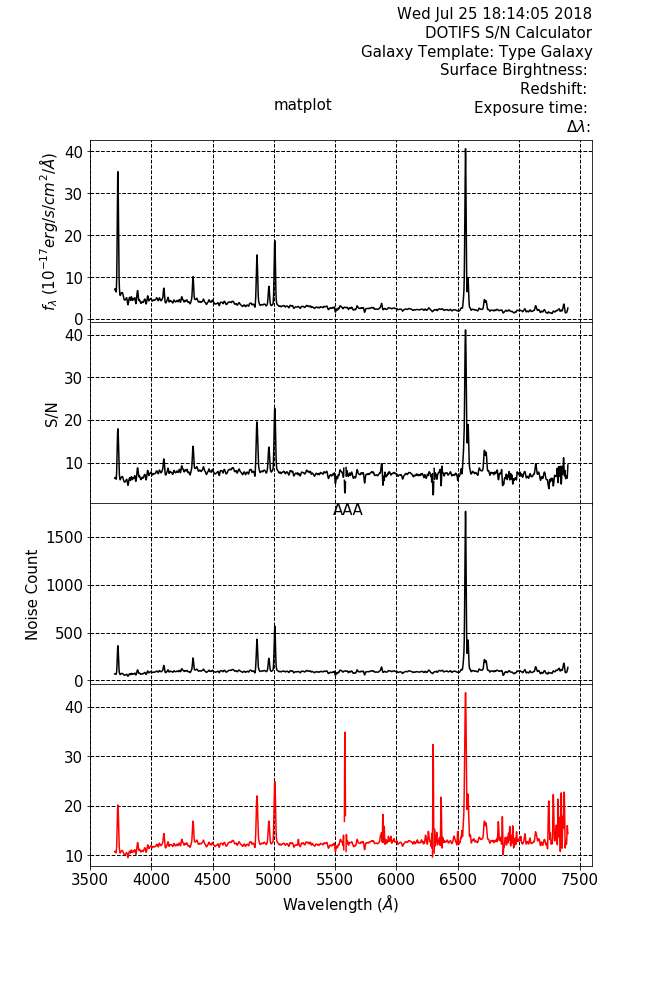

In [221]:
matplotlib.rcParams.update({'font.size':15})
font = {'family' : 'DejaVu Sans',
'weight' : 'normal',
'size'   : 15}

upmar=1.04
lwmar=0.995
wavemar=200

matplotlib.rc('font', **font)


xlim=[min(pwave)-wavemar,max(pwave)+wavemar]

plt.clf
fig=plt.figure(figsize=(9,13))
#gs1=matplotlib.gridspec.GridSpec(8,12)
gs1=gridspec.GridSpec(4,1, left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
gs1.tight_layout(fig, rect=[0,0,0.1,1])
gs1.update(hspace=0)
#gs1.tight_layout(fig, rect=[0,0,1,0.5])
#ax=plt.subplot(211)
ax0=plt.subplot(gs1[0])
ax0.plot(pwave, psourceflux/1e-17, 'k', linestyle='-')
ax0.set_xlim(xlim)
ax0.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
ax0.set_ylabel("$f_{\lambda}\;(10^{-17} erg/s/cm^{2}/\AA$)")
plt.text(5000,50, 'matplot')
#.set_xticks([4000,5000,6000,7000])

print(psourceflux)
#ax=plt.subplot(212)r



ax1=plt.subplot(gs1[1])
ax1.plot(pwave, psnr, 'k', linestyle='-')
#ax.set_ylabel("S/N", fontsize=20)
#ax.set_xlabel("Wavelength $\AA$ ", fontsize=20)
ax1.set_ylabel("S/N")
ax1.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
ax1.xaxis.set_minor_locator(plt.MultipleLocator(200))
ax1.set_xlim(xlim)
#ax.xlim([2000,10000])


ax.set_xlim(xlim)
#ax0.grid(b=True, which='major', color='r', linestyle='--', linewidth=1)
ax0.set_xlim(xlim)
ax.set_ylim(ylim)

'''
plt.subplot(231)
plt.subplot(236)
plt.subplot(235)
plt.subplot(234)
'''

ax2=plt.subplot(gs1[2])
ax2.plot(pwave, psignal, 'k', linestyle='-')
ax2.set_xlim(xlim)
ax2.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
ax2.set_ylabel("Signal Count")

ax3=plt.subplot(gs1[3])
ax3.plot(pwave, pnoise, 'r', linestyle='-')
ax3.set_xlim(xlim)
ax3.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
ax3.set_xlabel("Wavelength ($\AA$) ")
ax2.set_ylabel("Noise Count")

ax0.tick_params(labelbottom=False)
ax1.tick_params(labelbottom=False)
ax2.tick_params(labelbottom=False)
#ax3.tick_params(labelbottom=True)
#ax0.axes.set_xticks([4000,5000,6000,7000])

#plt.text(0.5, 1.2, 'matplotlib', horizontalalignment='center',
#         verticalalignment='center', transform=ax.transAxes)

#plt.scatter(wave, snr)

remarks=[time.asctime( time.localtime(time.time()) ),
         'DOTIFS S/N Calculator',
         'Galaxy Template: '+temptitle,
         'Surface Birghtness: ',
         'Redshift: ',
         'Exposure time: ',
         '$\Delta\lambda$: ',
        ]
         
nremarks=len(remarks)

yitv=0.02
ax = fig.add_axes([0,0,1,1], facecolor="None", frameon=False, label="")
ax.text(0.5,0.5, 'AAA')
ax.tick_params(labelbottom=False, labelleft=False, length=0)
#ax.text(0.9, 0.9, 'TEST',horizontalalignment='right')
for i in range(nremarks):
    ax.text(0.9, 0.91+yitv*i, remarks[nremarks-i-1],horizontalalignment='right')

plt.show()
        
#def codetest():
#    dotifs_etc(300)
#codetest()